In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit
import random

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [3]:
G = nx.Graph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [4]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))
G = S[0]

The total number of components is:  12219


In [5]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [9]:
G_bipartite = nx.Graph()
for node in nodes:
    if list(node.labels)[0] != 'Entity':
        if node.id in G.nodes:
            G_bipartite.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)
vuelta = 0
for officer in labels['Officer']:
    officer_dict = {}
    for officer_neighbors in G.edges(officer):
        for entity_neighbors in G.edges(officer_neighbors[1]):
            if G.nodes[entity_neighbors[1]]['kind'] == 'Intermediary':
                if entity_neighbors[1] in officer_dict:
                    officer_dict[entity_neighbors[1]] =  officer_dict[entity_neighbors[1]] +1
                else:
                    officer_dict[entity_neighbors[1]] = 1
    for k,v in officer_dict.items():
        G_bipartite.add_edge(officer, k, weight=v, type='Interactions')

In [11]:
A=nx.bipartite.biadjacency_matrix(G_bipartite, labels['Officer'], labels['Intermediary'])

In [13]:
A.todense()

matrix([[   1,    0,    0, ...,    0,    0,    0],
        [1947,   23,   20, ...,    0,    0,    0],
        [   1,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [22]:
labels['Officer'][1]

481167

In [47]:
labels['Intermediary'][1]

214676

In [23]:
G_bipartite[481167][215896]

{'weight': 1947, 'type': 'Interactions'}

In [17]:
 labels['Intermediary'][0]

215896

In [24]:
G_bipartite.degree[215896]

9183

In [29]:
for k,v in G_bipartite.degree(labels['Officer']):
    if v > 1:
        print(k,v)

481167 306
498002 2
470123 3
496323 2
495424 2
440302 2
424949 2
433654 2
435752 2
482743 2
474906 34
474905 30
527105 2
537888 3
480444 12
414758 2
473300 2
493119 58
422847 2
422767 2
508399 2
491984 2
451102 2
493091 10
477105 2
473301 2
483221 2
522537 2
473773 2
481577 3
473792 3
465953 11
422928 2
444179 2
493075 3
485725 3
497997 16
485287 33
541369 2
529896 2
422930 2
428250 4
428246 5
527142 2
483550 2
511179 2
521767 7
437658 2
510499 2
417455 2
493219 25
427675 2
522989 2
416297 2
414847 2
437938 4
437937 4
447926 2
419909 2
422025 2
480401 6
541598 2
422106 2
434728 2
496271 2
493354 2
537354 4
451103 2
497998 3
442726 2
535295 2
470501 7
494641 2
420449 2
461291 3
481878 13
452941 20
479305 3
434969 2
404616 2
389453 2
519993 2
425936 3
494753 20
537098 2
441269 2
523704 2
506318 2
431759 2
536246 3
522884 2
426665 2
425042 2
480311 2
521730 2
515691 2
467760 2
450332 2
493352 2
469342 2
445401 2
536220 2
414948 2
458847 3
506645 2
466166 2
426208 4
474446 3
333170 2
52313

507234 2
479163 2
469281 2
412748 2
412670 2
522881 2
445452 5
445450 5
441443 2
486842 2
477261 3
426134 2
502877 3
435195 8
508287 2
532317 2
453719 2
494244 2
463892 2
539580 2
525555 2
339906 2
446826 2
446825 2
463331 2
499366 3
495059 3
542765 2
511010 2
535941 2
539776 2
505755 2
494103 2
499565 2
497427 2
497426 2
460149 2
456603 2
440848 6
424000 3
517564 2
372719 2
372378 2
517862 2
556875 3
372379 2
372081 2
457657 3
457735 2
482758 3
493188 5
559667 3
559666 3
497756 3
495060 3
444174 2
514690 2
514689 2
414833 2
502830 2
442407 2
426440 2
493076 2
542368 2
502903 2
502902 2
516144 2
449881 2
480334 2
426658 2
494724 2
462447 2
431548 3
447664 2
422532 2
420182 2
456544 2
457778 3
451993 2
494625 2
453871 2
502734 2
487982 2
500471 4
439102 2
507319 2
441892 2
476593 2
500468 3
417167 2
495896 3
509843 9
449857 2
455287 2
482528 2
482527 3
448094 3
495645 5
536678 2
413823 2
450406 2
464165 2
484457 2
476521 2
429479 2
429480 2
428574 2
442904 2
437846 2
435521 3
450880 2
4

In [40]:
officer_dict = dict(G_bipartite.degree(labels['Officer']))
sorted_officer_dict = list(dict(sorted(officer_dict.items(), key=lambda item: item[1],reverse=True)).keys())

intermediary_dict = dict(G_bipartite.degree(labels['Intermediary']))
sorted_intermediary_dict = list(dict(sorted(intermediary_dict.items(), key=lambda item: item[1],reverse=True)).keys())

In [41]:
A=nx.bipartite.biadjacency_matrix(G_bipartite, sorted_officer_dict, sorted_intermediary_dict)

In [42]:
A.todense()

matrix([[1947,   57,   60, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [43]:
sorted_officer_dict[0]

481167

In [74]:
sorted_intermediary_dict[1656]

224597

In [45]:
G_bipartite[481167][215862]

{'weight': 57, 'type': 'Interactions'}

In [48]:
G_bipartite[481167][214676]

{'weight': 23, 'type': 'Interactions'}

In [50]:
len(labels['Intermediary'])

1762

In [75]:
G_bipartite.degree(224597)

2

In [81]:
print(A[154451,:])

  (0, 1656)	1


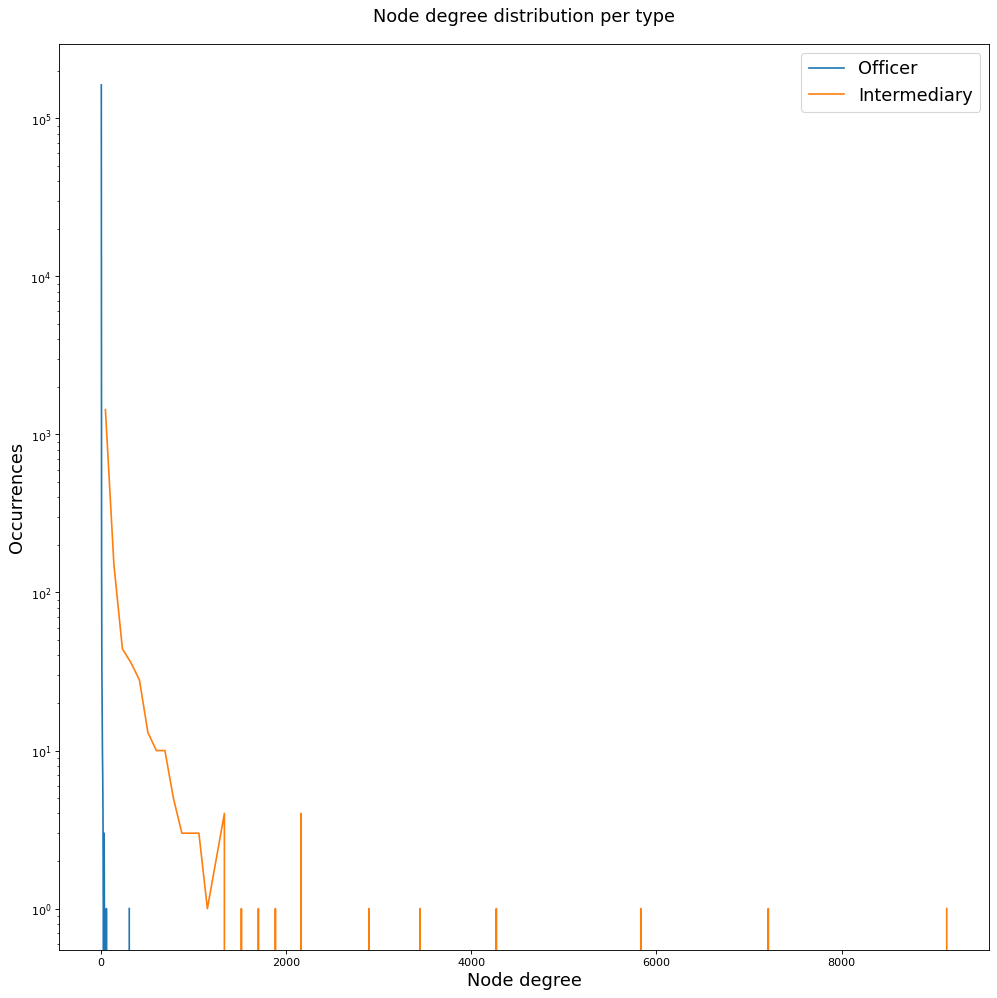

In [68]:
histogram_degrees_officer = list(dict(G_bipartite.degree(labels['Officer'])).values())
histogram_degrees_intermediaries = list(dict(G_bipartite.degree(labels['Intermediary'])).values())

plt.figure(figsize=(15, 15), dpi=80)

y,binEdges=np.histogram(histogram_degrees_officer,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Officer")

y,binEdges=np.histogram(histogram_degrees_intermediaries,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Intermediary")

plt.title('Node degree distribution per type',fontsize=16,pad=20)
plt.xlabel('Node degree',fontsize=16)
plt.ylabel('Occurrences',fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
p.show()